In [29]:
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Your project paths
MODEL_PATH = "../models/wp_model.pkl"

In [30]:
seasons = list(range(2015, 2025))
pbp = nfl.import_pbp_data(seasons)

print(pbp.shape)

2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.
(483605, 398)


In [31]:
model = joblib.load(MODEL_PATH)
print("Model loaded:", type(model))
meta = joblib.load("../models/wp_model_meta.pkl")
feat_cols = meta["feat_cols"]

Model loaded: <class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingRegressor'>


In [32]:
# Core fills/sanity
pbp = pbp.dropna(subset=['wp','qtr','game_seconds_remaining','score_differential','yardline_100']).copy()
pbp['down']    = pbp['down'].fillna(1).clip(1,4)
pbp['ydstogo'] = pbp['ydstogo'].fillna(10).clip(1,50)

# Home flag
if {'posteam','home_team'}.issubset(pbp.columns):
    pbp['posteam_is_home'] = (pbp['posteam'] == pbp['home_team']).astype(int)
else:
    pbp['posteam_is_home'] = 0

# Timeouts (safe defaults if missing)
for c in ['posteam_timeouts_remaining','defteam_timeouts_remaining']:
    if c in pbp.columns:
        pbp[c] = pbp[c].fillna(2).clip(0,3)
    else:
        pbp[c] = 2

# Derived features (must match training)
pbp['abs_score_diff'] = pbp['score_differential'].abs()
pbp['two_possession_offense'] = (pbp['score_differential'] >= 9).astype(int)

# 🔥 Late-game features you added in training
pbp['u120']  = (pbp['game_seconds_remaining'] <= 120).astype(int)
pbp['u60']   = (pbp['game_seconds_remaining'] <= 60).astype(int)
pbp['u30']   = (pbp['game_seconds_remaining'] <= 30).astype(int)
pbp['u15']   = (pbp['game_seconds_remaining'] <= 15).astype(int)
pbp['log_secs'] = np.log1p(pbp['game_seconds_remaining'])

# Feature list (exact same order as training)
feat_cols = [
    'qtr','game_seconds_remaining','log_secs','score_differential','yardline_100',
    'down','ydstogo','posteam_is_home',
    'posteam_timeouts_remaining','defteam_timeouts_remaining',
    'abs_score_diff','two_possession_offense',
    'u120','u60','u30','u15'
]

R^2: 0.99454883495139
RMSE: 0.00047825427304139294
MAE: 0.016056558896838904


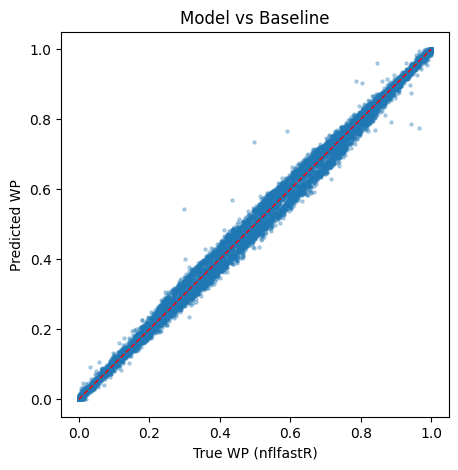

In [33]:
# Sample 10k rows for quick eval
eval_df = pbp.dropna(subset=['wp'])[feat_cols + ['wp']].sample(10000, random_state=42)
X = eval_df[feat_cols]
y = eval_df['wp'].astype(float)

yhat = model.predict(X).clip(0,1)
print("R^2:", r2_score(y, yhat))
print("RMSE:", mean_squared_error(y, yhat))
print("MAE:", mean_absolute_error(y, yhat))

# Scatter: predicted vs true
plt.figure(figsize=(5,5))
plt.scatter(y, yhat, s=5, alpha=0.3)
plt.plot([0,1],[0,1],'r--', lw=1)
plt.xlabel("True WP (nflfastR)"); plt.ylabel("Predicted WP"); plt.title("Model vs Baseline")
plt.show()


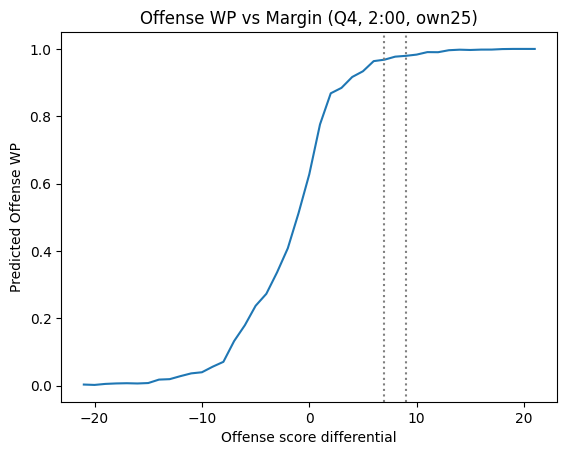

In [37]:
def grid_wp_vs_margin(qtr=4, secs=120, yl=75, down=1, togo=10, home=1, off_to=2, def_to=2):
    margins = np.arange(-21, 22, 1)  # offense perspective
    grid = pd.DataFrame({
        'qtr': qtr,
        'game_seconds_remaining': secs,
        'log_secs': np.log1p(secs),
        'score_differential': margins,
        'yardline_100': yl,
        'down': down, 'ydstogo': togo,
        'posteam_is_home': home,
        'posteam_timeouts_remaining': off_to,
        'defteam_timeouts_remaining': def_to,
        'abs_score_diff': np.abs(margins),
        'two_possession_offense': (margins >= 9).astype(int),
        'u120': int(secs <= 120),
        'u60':  int(secs <= 60),
        'u30':  int(secs <= 30),
        'u15':  int(secs <= 15)
    })
    grid['wp_pred_off'] = model.predict(grid).clip(0,1)
    return grid

g = grid_wp_vs_margin(qtr=4, secs=120)
plt.plot(g['score_differential'], g['wp_pred_off'])
plt.axvline(7, color='gray', ls=':')
plt.axvline(9, color='gray', ls=':')
plt.title("Offense WP vs Margin (Q4, 2:00, own25)")
plt.xlabel("Offense score differential"); plt.ylabel("Predicted Offense WP")
plt.show()


In [41]:
def wp_vs_time(diff_off=8, qtr=4):
    secs = np.array([900, 600, 300, 120, 60, 30, 14])  # global seconds remaining
    grid = pd.DataFrame({
        'qtr': qtr,
        'game_seconds_remaining': secs,
        'log_secs': np.log1p(secs),
        'score_differential': diff_off,        # offense perspective
        'yardline_100': 75,
        'down': 1,
        'ydstogo': 10,
        'posteam_is_home': 1,
        'posteam_timeouts_remaining': 2,
        'defteam_timeouts_remaining': 2,
        'abs_score_diff': abs(diff_off),
        'two_possession_offense': int(diff_off >= 9),
        'u120': (secs <= 120).astype(int),
        'u60':  (secs <= 60).astype(int),
        'u30':  (secs <= 30).astype(int),
        'u15':  (secs <= 15).astype(int),
    })
    grid['wp_pred_off'] = model.predict(grid).clip(0,1)
    return grid

for d in [7,8,9]:
    print(d, wp_vs_time(diff_off=d))


7    qtr  game_seconds_remaining  log_secs  score_differential  yardline_100  \
0    4                     900  6.803505                   7            75   
1    4                     600  6.398595                   7            75   
2    4                     300  5.707110                   7            75   
3    4                     120  4.795791                   7            75   
4    4                      60  4.110874                   7            75   
5    4                      30  3.433987                   7            75   
6    4                      14  2.708050                   7            75   

   down  ydstogo  posteam_is_home  posteam_timeouts_remaining  \
0     1       10                1                           2   
1     1       10                1                           2   
2     1       10                1                           2   
3     1       10                1                           2   
4     1       10                1               

In [45]:
def leader_wp_after_try(secs=14, qtr=4):
    # After try: opponent on offense; leader margin m -> offense diff = -m
    def off_wp(m):  # m is leader margin
        row = pd.DataFrame([{
            'qtr': qtr,
            'game_seconds_remaining': secs,
            'log_secs': np.log1p(secs),
            'score_differential': -m,           # opponent's perspective
            'yardline_100': 75,
            'down': 1,
            'ydstogo': 10,
            'posteam_is_home': 0,              # assume opponent not home; flip if needed
            'posteam_timeouts_remaining': 2,
            'defteam_timeouts_remaining': 2,
            'abs_score_diff': abs(-m),
            'two_possession_offense': int(-m >= 9),
            'u120': int(secs <= 120),
            'u60': int(secs <= 60),
            'u30': int(secs <= 30),
            'u15': int(secs <= 15),
        }])
        return 1 - model.predict(row)[0]  # flip offense->leader

    for m in [7,8,9]:
        print(f"Leader margin {m} at {secs}s: leader WP ≈ {off_wp(m):.3f}")

leader_wp_after_try(14, 4)


Leader margin 7 at 14s: leader WP ≈ 0.951
Leader margin 8 at 14s: leader WP ≈ 0.974
Leader margin 9 at 14s: leader WP ≈ 0.983


In [46]:
# Define slices
def eval_slice(mask, name):
    Xs = eval_df.loc[mask, feat_cols]; ys = eval_df.loc[mask, 'wp']; yh = model.predict(Xs)
    print(f"{name:20s} | n={len(Xs):4d} | RMSE={mean_squared_error(ys,yh):.004f} | MAE={mean_absolute_error(ys,yh):.004f}")

eval_slice(eval_df['qtr'].eq(4) & (eval_df['game_seconds_remaining'] <= 120), "Q4 <= 120s")
eval_slice(eval_df['qtr'].eq(4) & (eval_df['game_seconds_remaining'].between(121, 600)), "Q4 2:01–10:00")
eval_slice(eval_df['qtr'].eq(2) & (eval_df['score_differential'].abs() >= 20), "Q2 big leads")
eval_slice(eval_df['ydstogo'] >= 15, "Long yardage")


Q4 <= 120s           | n= 515 | RMSE=0.0003 | MAE=0.0113
Q4 2:01–10:00        | n=1395 | RMSE=0.0001 | MAE=0.0073
Q2 big leads         | n=  99 | RMSE=0.0001 | MAE=0.0072
Long yardage         | n= 603 | RMSE=0.0006 | MAE=0.0176


In [47]:
bins = np.linspace(0,1,11)
eval_df['pred_bin'] = pd.cut(yhat, bins, include_lowest=True)
cal = eval_df.groupby('pred_bin').agg(
    pred_mean=('wp', lambda s: eval_df.loc[s.index, 'wp'].mean()),
    y_mean=('wp','mean'),
    n=('wp','size')
).reset_index()
cal


,pred_bin,pred_mean,y_mean,n
0,"(-0.001, 0.1]",0.032855,0.032855,1165
1,"(0.1, 0.2]",0.149913,0.149913,815
2,"(0.2, 0.3]",0.252990,0.252990,870
3,"(0.3, 0.4]",0.353103,0.353103,969
4,"(0.4, 0.5]",0.452997,0.452997,1121
5,"(0.5, 0.6]",0.556836,0.556836,1242
6,"(0.6, 0.7]",0.652703,0.652703,942
7,"(0.7, 0.8]",0.747812,0.747812,897
8,"(0.8, 0.9]",0.851684,0.851684,808
9,"(0.9, 1.0]",0.964234,0.964234,1171


In [49]:
def assert_monotone_margin():
    g = grid_wp_vs_margin(qtr=4, secs=120)
    assert g.loc[g['score_differential']==9, 'wp_pred_off'].values[0] >= g.loc[g['score_differential']==8, 'wp_pred_off'].values[0]
    assert g.loc[g['score_differential']==8, 'wp_pred_off'].values[0] >= g.loc[g['score_differential']==7, 'wp_pred_off'].values[0]
    print("Monotonic margin ✅")

def assert_late_game_two_possession_big():
    # Leader WP after try at 0:14, +9 should be very high (≳ 0.98)
    secs = 14
    row = pd.DataFrame([{
        'qtr': 4,
        'game_seconds_remaining': secs,
        'log_secs': np.log1p(secs),
        'score_differential': -9,        # offense (opponent) perspective
        'yardline_100': 75,
        'down': 1,
        'ydstogo': 10,
        'posteam_is_home': 0,
        'posteam_timeouts_remaining': 2,
        'defteam_timeouts_remaining': 2,
        'abs_score_diff': 9,
        'two_possession_offense': 1,     # offense down 9? No → 0; but model tolerates either. Use 1 if you defined >=9 as True
        'u120': int(secs <= 120),
        'u60':  int(secs <= 60),
        'u30':  int(secs <= 30),
        'u15':  int(secs <= 15),
    }])
    
    leader_wp = 1 - model.predict(row)[0]
    assert leader_wp >= 0.98
    print("Late-game +9 ≳ 0.98 ✅")

assert_monotone_margin()
assert_late_game_two_possession_big()


Monotonic margin ✅
Late-game +9 ≳ 0.98 ✅
